In [45]:
import pathlib
import configparser
import os
import glob
import numpy as np
import pyvista as pv
import pandas as pd
import h5py
from svd_dataset import SVD
import tensorflow as tf


class CaseConfigParser(configparser.ConfigParser):
    def optionxform(self, optionstr):
        return optionstr


def clear_vtm(solution_file, output_file):
    multiblock = pv.read(solution_file)
    for i in range(len(multiblock)):
        for j in range(len(multiblock[i])):
            for k in range(len(multiblock[i][j])):
                multiblock[i][j][k].clear_point_data()
    multiblock.save(output_file)

    return pv.read(output_file)


def read_config_file(config_file):
    config = CaseConfigParser()
    config.read(config_file)

    # convert all path to the absolute
    for each_section in config.sections():
        for (each_key, each_val) in config.items(each_section):
            value = pathlib.Path(config[each_section][each_key])
            if value.is_file() or value.is_dir():
                config[each_section][each_key] = f"{value.resolve()}"
    return config


def get_converged_solutions(root_path, solution_path):
    solutions_id = []
    n_directories = len(
        list(filter(os.path.isdir, glob.glob(f'{root_path}/*'))))
    for i in range(n_directories):
        solution_file = f'{root_path}/{i+1}/{solution_path}'
        if len(list(glob.glob(f'{solution_file}*'))) > 0:
            solutions_id.append(i+1)

    return solutions_id


def sliceDataAlongAxis(data, fractions, axis):
    data_size = data.shape[axis]
    fractions_ = np.zeros_like(fractions, dtype=int)

    total_size = 0
    for i, fraction in enumerate(fractions):
        total_size += int(data_size*fraction)
    remain = data_size-total_size

    slices = ()
    for i, fraction in enumerate(fractions):
        fractions_[i] = int(data_size*fraction)
        if i > 0:
            fractions_[i] += fractions_[i-1]
            slice = data.take(range(fractions_[i-1], fractions_[i]), axis)

        else:
            slice = data.take(range(0, fractions_[i]+remain), axis)

        slices += (slice,)

    return slices


class NeuralNetwork:
    def __init__(self):

        self.name = 'neural_network'

    def set_model(self,
                  layers,
                  activation_function='tanh',
                  optimizer=tf.keras.optimizers.Adam(),
                  hidden_layers=None):

        self.nn = self.get_model(layers, activation_function, optimizer)

    def get_model(self, layers, activation_function, optimizer):
        # Input layer
        ph_input = tf.keras.Input(shape=(layers[0],), name='input_placeholder')
        # Hidden layers
        hidden_layer = ph_input
        for num_neurons in layers[1:-1]:
            hidden_layer = tf.keras.layers.Dense(
                num_neurons, activation=activation_function)(hidden_layer)

        # Output layer
        output = tf.keras.layers.Dense(
            layers[-1], activation='linear', name='output_value')(hidden_layer)

        model = tf.keras.Model(inputs=[ph_input], outputs=[output])
        # Compilation
        model.compile(optimizer=optimizer, loss={
                      'output_value': 'mean_squared_error'})

        return model

    def fit(self,
            train_input,
            train_target,
            validation_input=None,
            validation_target=None,
            epochs=1000,
            batch_size=16):

        if validation_input is not None and validation_target is not None:
            validation_tuple = (validation_input, validation_target)

        self.history = self.nn.fit(train_input, train_target, epochs=epochs,
                                   batch_size=batch_size, validation_data=validation_tuple)

        return self.nn, self.history

    def predict(self, input):
        if len(input.shape) == 1:
            input = input[None, :]
        return self.nn.predict(input)

    def save(self, file):
        self.nn.save(file)

    def load(self, file):
        self.nn = tf.keras.models.load_model(file)


class dataHandler:
    def __init__(self, file, variables):
        self.file = file
        self.variables = variables
        self.stack()

    def stack(self):
        with h5py.File(self.file, 'r') as f:
            self.h5 = f
            self.data = np.vstack([f[var][()] for var in self.variables])

            self.indexes = {}
            start_idx = 0
            for var in self.variables:
                try:
                    end_idx = start_idx + f[var][()].shape[0]
                except:
                    # f[var] is a scalar
                    end_idx = start_idx + 1
                self.indexes[var] = np.arange(start_idx, end_idx)
                start_idx = end_idx

            if 'meshfile' in f.keys():
                self.meshfile = f['meshfile'][()]

    def get_variable(self, variable=None, data=None,):
        if data is None:
            data = self.data

        return data[self.indexes[variable], :]

    def split_train_validation_test(self, fractions):
        self.train, self.validation, self.test = sliceDataAlongAxis(
            self.data, fractions, 1)


class ROM:
    def __init__(self, dataset, rank=None, energy=None):

        self.svd = SVD(dataset)

        self.bounds = [0, 1]

        self.svd.normalize(bounds=self.bounds)
        self.svd.subtractMean()
        self.svd.SVD()
        if rank is not None and energy is None :
            self.setRank(rank)
        if energy is not None:
            self.findRank(energy)

    def setRank(self, rank):
        self.rank = rank
        self.svd.setRank(self.rank)

    def findRank(self, energy):
        rank = self.svd.findRank(energy)
        self.rank = rank

    def setEnergy(self, e):
        self.energyPreserved = e
        self.rank = self.svd.findRank(self.energyPreserved)
        self.svd.setRank(self.rank)

    def reduce(self, snapshot):
        if len(snapshot.shape) == 1:
            snapshot = snapshot[:, None]
        snapshot, min, max = self.svd.normalize(
            snapshot, self.bounds, self.svd.min, self.svd.max)
        snapshot, mean = self.svd.subtractMean(snapshot, self.svd.mean)
        L = (self.svd.u.T @ snapshot).T
        return L

    @property
    def data(self):
        return self.svd.L

    @property
    def L(self):
        return self.svd.L

    def reconstruct(self, input):
        return self.svd.reconstruct(input)


class FlowReconstruction:
    def __init__(self):
        pass

    def set_config_file(self, config_file):
        self.config_file = pathlib.Path(config_file).absolute()
        self.config = read_config_file(self.config_file)
        self.dataset_root = pathlib.Path(
            self.config['DATASET']['DATASET_ROOT']).absolute()
        self.doe_file = self.dataset_root / \
            pathlib.Path(self.config['DATASET']['DOEFILE'])

        self.LF_PARAMS = dict(self.config['LF_PARAMS'])
        self.HF_PARAMS = dict(self.config['HF_PARAMS'])

    def get_converged_solutions(self):
        self.converged_solutions_id = get_converged_solutions(
            self.dataset_root, self.hf_solution_file)

    def set_lf_solution_path(self, path):
        self.lf_solution_path = pathlib.Path(path)

    def set_hf_solution_path(self, path):
        self.hf_solution_path = pathlib.Path(path)

    def set_hf_solution_file(self, file):
        self.hf_solution_file = pathlib.Path(self.hf_solution_path / file)

    def set_lf_variable_getter(self, variable_getter, variables_dict):
        self.lf_variables_dict = variables_dict
        self.lf_variable_getter = variable_getter

    def get_lf_variable(self, variable, idx=None, solution_path=None):
        if solution_path is None and idx is not None:
            solution_path = self.dataset_root / \
                str(idx) / self.lf_solution_path
        else:
            # solution_path = pathlib.Path(solution_path) / self.lf_solution_path
            pass
        return self.lf_variable_getter(self.lf_variables_dict, variable, solution_path)

    def get_lf_variables(self, solution_path=None, variables=None, include_design_variable=True):
        if solution_path is None:
            solution_path = self.lf_fom_rootfile

        snapshot = []

        if include_design_variable:
            for var, value in self.lf_design_variables.items():
                snapshot.append(value)
        if variables is None:
            variables = self.lf_variables_dict.keys()
        for var in variables:
            value = self.get_lf_variable(
                variable=var, solution_path=solution_path)
            snapshot.append(value)

        return np.hstack(snapshot)

    def get_hf_variables(self, solution_file=None):
        if solution_file is None:
            solution_file = self.hf_fom_

    def set_hf_variable_getter(self, variable_getter, variables_dict):
        self.hf_variables_dict = variables_dict
        self.hf_variable_getter = variable_getter

    def get_hf_variable(self, variable, idx=None, solution_file=None):
        if solution_file is None and idx is not None:
            solution_file = self.dataset_root / \
                str(idx) / self.hf_solution_file
        else:
            # inconsistent !
            solution_file = pathlib.Path(solution_file) / self.hf_solution_path

        return self.hf_variable_getter(self.hf_variables_dict, variable, solution_file)

    def get_hf_snapshot(self, idx=None, solution_file=None, include_design_variables=True):
        if solution_file is None and idx is not None:
            solution_file = self.dataset_root / \
                str(idx) / self.hf_solution_file

        snapshot = {}
        if include_design_variables == True:
            df = pd.read_csv(self.doe_file).set_index('ID')
            design_variables = df.keys()
        elif include_design_variables == False:
            design_variables = []
        else:
            design_variables = include_design_variables

        for var in design_variables:
            snapshot[var] = df[var][idx]

        for var in self.hf_variables_dict.keys():
            if idx is not None:
                snapshot[var] = self.get_hf_variable(var, idx)
            elif solution_file is not None:
                snapshot[var] = self.get_hf_variable(
                    variable=var, solution_file=solution_file)

        return snapshot

    def get_lf_snapshot(self, idx=None, solution_path=None, include_design_variables=True):
        if solution_path is None and idx is not None:
            solution_path = self.dataset_root / \
                str(idx) / self.lf_solution_path
        elif solution_path is None:
            solution_path = pathlib.Path(solution_path) / self.lf_solution_path

        snapshot = {}
        if include_design_variables is True:
            df = pd.read_csv(self.doe_file).set_index('ID')
            design_variables = df.keys()
            for var in design_variables:
                snapshot[var] = df[var][idx]
        elif include_design_variables is False:
            design_variables = []
        else:
            design_variables = include_design_variables

            for key, var in design_variables.items():
                snapshot[key] = var

        for var in self.lf_variables_dict.keys():
            if idx is not None:
                snapshot[var] = self.get_lf_variable(var, idx)
            elif solution_path is not None:
                snapshot[var] = self.get_lf_variable(
                    variable=var, solution_path=solution_path)

        return snapshot

    def get_lf_snapshots(self, include_design_variables=True):
        snapshots = []
        for id in self.converged_solutions_id:
            snapshot = self.get_lf_snapshot(
                idx=id, include_design_variables=include_design_variables)
            snapshots.append(snapshot)
        # self.lf_variables = snapshot.keys()
        return snapshots

    def get_hf_snapshots(self, include_design_variables=True):
        snapshots = []
        for id in self.converged_solutions_id:
            snapshot = self.get_hf_snapshot(
                idx=id, include_design_variables=include_design_variables)
            snapshots.append(snapshot)

        # self.hf_variables = snapshot.keys()
        return snapshots

    def gen_HDF5(self, snapshots, h5_filename):
        with h5py.File(h5_filename, 'w') as h5file:
            len(snapshots)
            for key in snapshots[0].keys():
                n_rows = snapshots[0][key].size
                h5file[key] = np.zeros((n_rows, len(snapshots)))

                for i, snap_i in enumerate(snapshots):
                    h5file[key][:, i] = snap_i[key]

    def gen_lf_HDF5(self, h5_filename, snapshots=None, include_design_variables=True):
        self.lf_h5file = self.dataset_root / h5_filename
        if snapshots is None:
            snapshots = self.get_lf_snapshots(
                include_design_variables=include_design_variables)
        self.gen_HDF5(snapshots, self.lf_h5file)
        self.lf_variables = snapshots[0].keys()

    def gen_hf_HDF5(self, h5_filename, snapshots=None, include_design_variables=True):
        self.hf_h5file = self.dataset_root / h5_filename
        if snapshots is None:
            snapshots = self.get_hf_snapshots(
                include_design_variables=include_design_variables)
        self.gen_HDF5(snapshots, self.hf_h5file)
        self.hf_variables = snapshots[0].keys()

    def set_lf_data_handler(self, train_validation_test_fractions):
        self.lf_data_handler = dataHandler(
            self.lf_h5file, self.lf_variables)
        self.lf_data_handler.split_train_validation_test(
            train_validation_test_fractions)

    def set_hf_data_handler(self, train_validation_test_fractions):
        self.hf_data_handler = dataHandler(
            self.hf_h5file, self.hf_variables)
        self.hf_data_handler.split_train_validation_test(
            train_validation_test_fractions)

    def set_lf_rom(self, rom, **rom_config):
        self.lf_rom_config = rom_config
        self.lf_rom = rom(self.lf_data_handler.train, **rom_config)
        self.lf_rom_rank = self.lf_rom.rank

    def set_hf_rom(self, rom, **rom_config):
        self.hf_rom_config = rom_config
        self.hf_rom = rom(self.hf_data_handler.train, **rom_config)
        self.hf_rom_rank = self.hf_rom.rank

    def set_lf_fom(self, lf_fom):
        self.lf_fom = lf_fom

    def set_hf_fom(self, hf_fom):
        self.hf_fom = hf_fom

    def run_lf_fom(self, rootfile, **other_params):
        self.lf_fom_rootfile = f"{pathlib.Path(self.dataset_root / rootfile)}/"
        print(self.LF_PARAMS)
        self.lf_design_variables = dict(other_params)
        self.lf_fom(rootfile=self.lf_fom_rootfile, **
                    self.LF_PARAMS, **other_params)

    def run_hf_fom(self, rootfile, **other_params):
        self.hf_fom_rootfile = f"{pathlib.Path(self.dataset_root / rootfile)}/"
        print(self.HF_PARAMS)
        self.hf_design_variables = dict(other_params)
        self.hf_fom(rootfile=self.hf_fom_rootfile, **
                    self.HF_PARAMS, **other_params)

    def reconstruct_snapshot(self):
        pass

    def reconstruct(self, rootfile, **other_params):
        def sub_dict(d, keys): return dict((key, d[key]) for key in keys)

        self.run_lf_fom(rootfile, **other_params)
        self.run_hf_fom(rootfile, only_generate_mesh=True, **other_params)

        self.hf_reconstructed_file = self.hf_fom_rootfile / \
            self.hf_solution_path / 'reconstructed.vtm'
        clear_vtm(self.hf_fom_rootfile / self.hf_solution_file,
                  self.hf_reconstructed_file)

        # lf_fom_solution = self.get_lf_variables(solution_path=self.lf_fom_rootfile)
        lf_solution_path = self.lf_fom_rootfile
        lf_fom_solution = self.get_lf_snapshot(
            lf_solution_path, include_design_variables=sub_dict(other_params, ['Thickness']))

        lf_fom_solution = set_thickness_distribution(
            snapshots=[lf_fom_solution])

        lf_fom_solution = np.hstack(
            [val for key, val in lf_fom_solution[0].items()])

        lf_projected = self.lf_rom.reduce(lf_fom_solution)
        hf_projected = self.surrogate.predict(lf_projected)
        hf_reconstructed = self.hf_rom.reconstruct(hf_projected)

        reconstructed_mesh = pv.read(self.hf_reconstructed_file)

        for variable, index in fr.hf_variables_dict.items():
            value = self.hf_data_handler.get_variable(
                variable=variable, data=hf_reconstructed)
            get_block_recursive(reconstructed_mesh,
                                index[:-1])[variable] = value

        reconstructed_mesh.save(self.hf_reconstructed_file)

    def set_surrogate(self, surrogate, surrogate_config):
        self.surrogate = surrogate()
        if self.surrogate.name == 'neural_network':
            surrogate_config['layers'] = [self.lf_rom_rank] + \
                surrogate_config['hidden_layers'] + [self.hf_rom_rank]

            self.surrogate.set_model(**surrogate_config)


In [46]:
# variable getter functions

def lf_variable_getter(variables_dict, variable, solution_path):
    outputs_path = pathlib.Path(solution_path) / 'outputs'
    inputs_path = pathlib.Path(solution_path) / 'inputs'

    if variables_dict[variable] in list(map(os.path.basename, glob.glob(f"{outputs_path}/*"))):
        solution_path = pathlib.Path(solution_path) / 'outputs'
    elif variables_dict[variable] in list(map(os.path.basename, glob.glob(f"{inputs_path}/*"))):
        solution_path = pathlib.Path(solution_path) / 'inputs'
    return np.loadtxt(solution_path / variables_dict[variable])


def get_block_recursive(block, name_index):
    for n in name_index:
        block = block[n]
    return block


def hf_variable_gatter(variables_dict, variable, solution_file):
    block = pv.read(solution_file)
    return get_block_recursive(block, variables_dict[variable])


In [47]:
fr = FlowReconstruction()

fr.set_config_file('/home/ppiper/Dropbox/local/ihtc_repository/src/doe_60.cfg')
fr.set_lf_solution_path('./Q1D/')
fr.set_hf_solution_path('./SU2/outputs/')
fr.set_hf_solution_file('cht_setupSU2.vtm')
fr.get_converged_solutions()

fr.set_lf_variable_getter(lf_variable_getter, variables_dict={
    #'Pressure' : 'p.txt',
    'Temperature': 'T.txt',
    #'Mach': 'M.txt',
    'Area': 'S.txt',
})

fr.set_hf_variable_getter(hf_variable_gatter, variables_dict={
    #'Pressure':
    #    ['Zone 0 (Comp. Fluid)', 'Internal', 'Internal', 'Pressure'],
    'Temperature':
        ['Zone 0 (Comp. Fluid)', 'Internal', 'Internal', 'Temperature'],
    #'Mach':
    #    ['Zone 0 (Comp. Fluid)', 'Internal', 'Internal', 'Mach'],
    'Temperature_Solid':
        ['Zone 1 (Solid Heat)', 'Internal', 'Internal', 'Temperature'],
    'Temperature_Solid_INNERWALL':
        ['Zone 1 (Solid Heat)', 'Boundary', 'INNERWALL', 'Temperature'],
    #'Heat_Flux_UPPER_WALL':
    #    ['Zone 0 (Comp. Fluid)', 'Boundary', 'UPPER_WALL', 'Heat_Flux'],
})


In [61]:
def set_thickness_distribution(snapshots):
    for i, snapshot in enumerate(snapshots):
        xcoordinate = snapshot['Area']
        thickness = snapshot['Thickness']
        snapshots[i]['Thickness'] = np.ones_like(xcoordinate)*thickness
    return snapshots


def select_variables(snapshots, variables):
    for i, snapshot in enumerate(snapshots):
        snapshots[i] = {
            var: snapshot[var] for var in variables}
    return snapshots


lf_snapshots = fr.get_lf_snapshots(include_design_variables=True)
lf_snapshots = set_thickness_distribution(snapshots=lf_snapshots)
lf_snapshots = select_variables(snapshots=lf_snapshots, variables=[
    'Area',
    'Thickness',
    #'Pressure',
    #'Temperature',
    #'Mach'
])


In [62]:
# fr.get_lf_variable(solution_path='/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/Q1D',variable='Pressure')

# fr.get_lf_variables(solution_path='/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/Q1D', include_design_variable=False)


In [63]:
fr.gen_lf_HDF5('lf.h5', snapshots=lf_snapshots, include_design_variables=False)


In [64]:
fr.gen_hf_HDF5('hf.h5', include_design_variables=False)


In [65]:
fr.set_lf_data_handler(train_validation_test_fractions=[0.8, 0.1, 0.1])


In [66]:
fr.set_hf_data_handler(train_validation_test_fractions=[0.8, 0.1, 0.1])


In [106]:
fr.set_lf_rom(ROM, rank=5)
#fr.set_lf_rom(ROM, energy=99.9)


In [107]:
fr.set_hf_rom(ROM, rank=10)
#fr.set_hf_rom(ROM, energy=99.9)


In [137]:
fr.set_surrogate(surrogate=NeuralNetwork,
                 surrogate_config=dict(
                     hidden_layers=[100]*2, activation_function='tanh',
                     optimizer=tf.keras.optimizers.Adam())
                 )


fr.surrogate.fit(
    train_input=fr.lf_rom.reduce(fr.lf_data_handler.train),
    train_target=fr.hf_rom.reduce(fr.hf_data_handler.train),
    validation_input=fr.lf_rom.reduce(fr.lf_data_handler.validation),
    validation_target=fr.hf_rom.reduce(fr.hf_data_handler.validation),
    epochs=300,
    batch_size=4)


Epoch 1/300
12/12 [==============================] - 1s 20ms/step - loss: 7.2628 - val_loss: 4.9451
Epoch 2/300
12/12 [==============================] - 0s 7ms/step - loss: 3.0876 - val_loss: 2.5138
Epoch 3/300
12/12 [==============================] - 0s 7ms/step - loss: 2.0697 - val_loss: 1.8794
Epoch 4/300
12/12 [==============================] - 0s 6ms/step - loss: 1.9510 - val_loss: 1.6452
Epoch 5/300
12/12 [==============================] - 0s 6ms/step - loss: 1.8153 - val_loss: 1.6180
Epoch 6/300
12/12 [==============================] - 0s 6ms/step - loss: 1.6838 - val_loss: 1.5720
Epoch 7/300
12/12 [==============================] - 0s 7ms/step - loss: 1.5487 - val_loss: 1.4976
Epoch 8/300
12/12 [==============================] - 0s 6ms/step - loss: 1.4247 - val_loss: 1.4008
Epoch 9/300
12/12 [==============================] - 0s 6ms/step - loss: 1.2892 - val_loss: 1.2745
Epoch 10/300
12/12 [==============================] - 0s 6ms/step - loss: 1.1438 - val_loss: 1.1762
Epoch 11

(<keras.engine.functional.Functional at 0x7fbb7bfeb2d0>,
 <keras.callbacks.History at 0x7fbb37eeded0>)

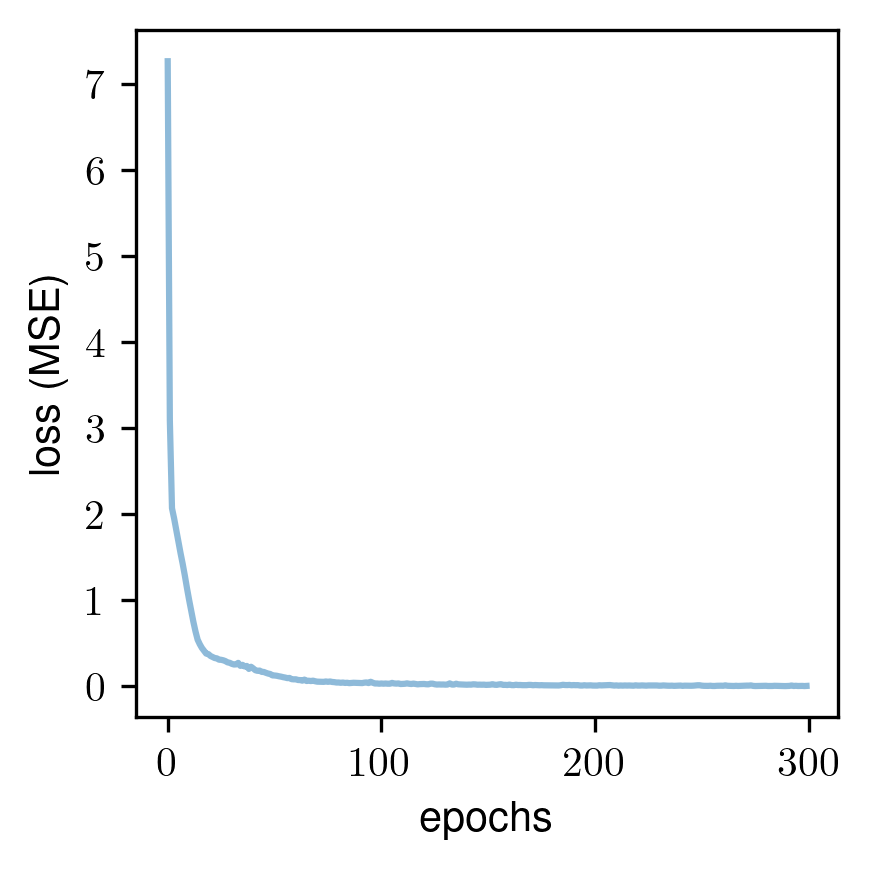

In [138]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['figure.dpi'] = 300

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(fr.surrogate.history.history['loss'], alpha=0.5)
plt.xlabel(r'epochs')
plt.ylabel(r'loss (MSE)')
plt.tight_layout()
plt.savefig('./figures/nn_training.pdf')
plt.show()

In [139]:
fr.surrogate.nn.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_placeholder (InputLay  [(None, 5)]              0         
 er)                                                             
                                                                 
 dense_47 (Dense)            (None, 100)               600       
                                                                 
 dense_48 (Dense)            (None, 100)               10100     
                                                                 
 output_value (Dense)        (None, 10)                1010      
                                                                 
Total params: 11,710
Trainable params: 11,710
Non-trainable params: 0
_________________________________________________________________


In [140]:
from models_parametric_shape import lf_model, hf_model

fr.set_lf_fom(lf_model)
fr.set_hf_fom(hf_model)


In [141]:
# fr.run_hf_fom(rootfile='./flow_reconstruction_60', Thickness=0.004, CP3_y=0.0025, only_generate_mesh=False)


In [142]:
#fr.reconstruct(rootfile='./flow_reconstruction_60',
#Thickness=0.008437333484435004, CP3_y=-0.012173731163813373)

In [143]:
lf_projected = fr.lf_rom.reduce(fr.lf_data_handler.test)
hf_projected = fr.surrogate.predict(lf_projected)
hf_reconstructed= fr.hf_rom.reconstruct(hf_projected)

1/1 [==============================] - 0s 79ms/step


In [144]:
# mach_rec = fr.hf_data_handler.get_variable('Mach',hf_reconstructed[:,2:3])


mesh = pv.read(
    '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/60/SU2/outputs/cht_setupSU2.vtm')


In [145]:
def plot_heat_flux():
    Heat_Flux_rec = fr.hf_data_handler.get_variable(
        'Heat_Flux_UPPER_WALL', hf_reconstructed[:, 5:6])
    idx = 0
    end_idx = -1
    plt.figure(figsize=(3, 3))
    plt.plot(
        np.linspace(0, 1, Heat_Flux_rec.size)[idx:end_idx],
        mesh['Zone 0 (Comp. Fluid)']['Boundary']['UPPER_WALL']['Heat_Flux'][idx:end_idx]/1e3,
        label=r'$CFD$', color='k')
    plt.plot(np.linspace(0, 1, Heat_Flux_rec.size)[idx:end_idx],
             Heat_Flux_rec[idx:end_idx]/1e3, label=r'$ROM$', alpha=0.5, ls='--')
    plt.ylabel(r'$Wall\; Heat Flux\; [KW/m^2]$')
    plt.xlabel(r'$x/L$')
    plt.legend()
    plt.tight_layout()
    plt.savefig('./figures/predicted_wall_heat_flux.pdf')
    plt.show()


#plot_heat_flux()


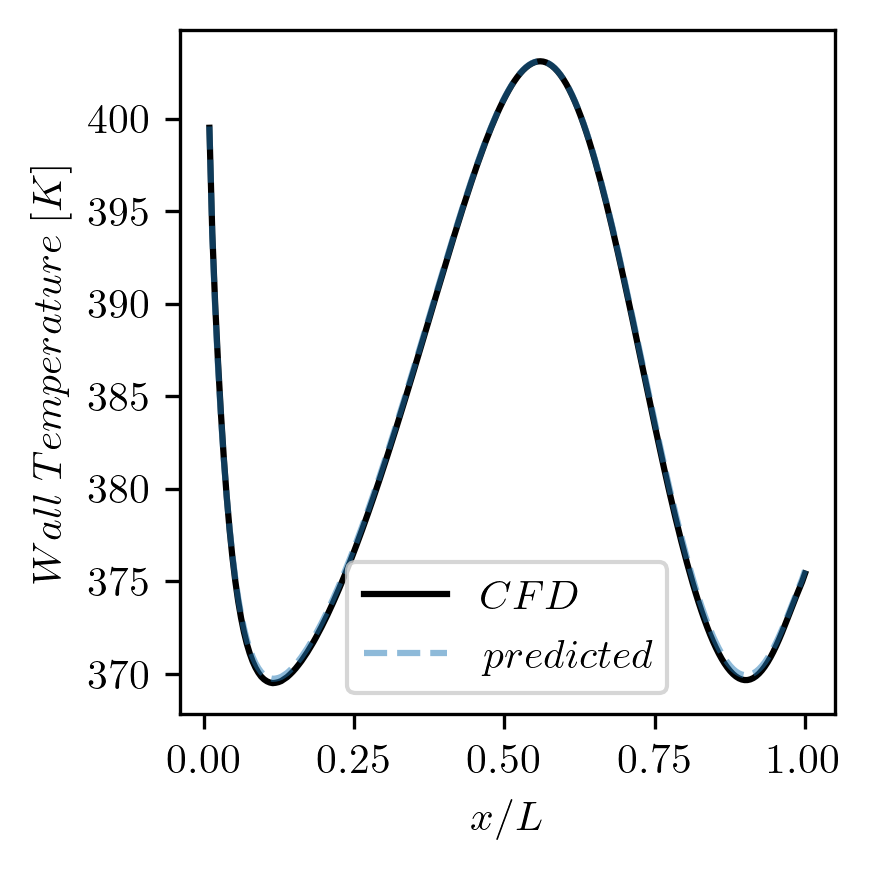

In [146]:
def plot_temperature_solid():
    T_solid_rec = fr.hf_data_handler.get_variable(variable='Temperature_Solid_INNERWALL',data=hf_reconstructed[:,5:6])

    idx=2
    plt.figure(figsize=(3,3))
    plt.plot(np.linspace(0,1,T_solid_rec.size)[idx:],mesh['Zone 1 (Solid Heat)']['Boundary']['INNERWALL']['Temperature'][idx:], label=r'$CFD$', color='k')
    plt.plot(np.linspace(0,1,T_solid_rec.size)[idx:],T_solid_rec[idx:], label=r'$predicted$', alpha=0.5, ls='--')
    plt.ylabel(r'$Wall\; Temperature\; [K]$')
    plt.xlabel(r'$x/L$')
    plt.legend()
    plt.tight_layout()
    plt.savefig('./figures/predicted_wall_temperature.pdf')
    plt.show()

plot_temperature_solid()

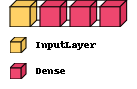

In [147]:
import visualkeras

visualkeras.layered_view(fr.surrogate.nn, legend=True)


In [148]:
def AE(x, y):
    # Mean Absolute Error
    return (abs(x-y))


def MeanAE(x, y):
    # Mean Absolute Error
    return np.mean(abs(x-y))


def MAE(x, y):
    # Maximum Absolute Error
    return np.max(abs(x-y))


def MAEP(x, y):
    # Maximum Absolute Error
    return MAE(x, y)*100


def NMAE(x, y):
    # Normalized Maximum Absolute Error
    return np.max(abs(x-y))/(np.max(x)-np.min(x))


def NMAEP(x, y):
    # Normalized Maximum Absolute Error
    return NMAE(x, y)*100


def MSE(x, y):
    # Mean Squared Error
    return np.mean((x-y)**2)

# colocar


def RMSE(x, y):
    # Root Mean Squared Error
    return np.sqrt(np.mean((x-y)**2))


def NRMSE(x, y):
    # Normalized Root Mean Squared Error
    # return np.sqrt(np.mean((x-y)**2))/np.mean(x)
    return np.sqrt(np.mean((x-y)**2))/(np.max(x)-np.min(x))


def NRMSEP(x, y):
    # Normalized Root Mean Squared Error
    # return np.sqrt(np.mean((x-y)**2))/np.mean(x)
    return NRMSE(x, y)*100


def MAPE(x, y):
    # Mean Absolute Percentage Error
    return np.mean(abs((x-y)/x))

# coloxae


def R2(x, y):
    # Coefficient of Determination
    return 1 - np.sum((x-y)**2)/np.sum((x-np.mean(y))**2)


def RSE(x, y):
    # Relative Squared Error
    return np.sum((x-y)**2) / np.sum((x - np.mean(x))**2)


def RAE(x, y):
    # Relative Squared Error
    return np.sum((x-y)**2) / np.sum((x - np.mean(y))**2)

# maximum absolute error


In [149]:
def plot_reconstruction_var(mesh, var, hf_reconstructed, metric=AE):
    hf_reconstructed = hf_reconstructed[:, None]

    pv.set_plot_theme("document")
    pv.global_theme.auto_close = True
    pl = pv.Plotter()
    pl.enable_anti_aliasing('ssaa')

    fluid = mesh['Zone 0 (Comp. Fluid)']['Internal']['Internal']
    fluid.set_active_scalars(var)
    if var == 'Temperature':
        solid = mesh['Zone 1 (Solid Heat)']['Internal']['Internal']
        solid.set_active_scalars(var)
        pl.add_mesh(solid)
    pl.add_mesh(fluid)
    pl.camera.tight()
    pl.show(
        screenshot=f'/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/figures/{var}_field_cfd.png')

    pv.set_plot_theme("document")
    pv.global_theme.auto_close = True
    pl = pv.Plotter()
    pl.enable_anti_aliasing('ssaa')

    fluid_rec = fr.hf_data_handler.get_variable(var, hf_reconstructed)[:, 0]
    fluid_var = np.copy(fluid[var])
    fluid[var] = fluid_rec

    if var == 'Temperature':
        solid = mesh['Zone 1 (Solid Heat)']['Internal']['Internal']
        solid_rec = fr.hf_data_handler.get_variable(
            f'{var}_Solid', hf_reconstructed)[:, 0]
        solid_var = np.copy(solid[var])
        solid[var] = solid_rec
        solid.set_active_scalars('Temperature')
        pl.add_mesh(solid)

    fluid.set_active_scalars(var)
    pl.add_mesh(fluid)
    pl.camera.tight()
    pl.show(
        screenshot=f'/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/figures/{var}_field_reconstructed.png')

    pv.set_plot_theme("document")
    pv.global_theme.auto_close = True
    pl = pv.Plotter()
    pl.enable_anti_aliasing('ssaa')

    AE_fluid = metric(fluid_var, fluid_rec)
    fluid[var] = AE_fluid

    if var == 'Temperature':
        solid = mesh['Zone 1 (Solid Heat)']['Internal']['Internal']
        AE_solid = metric(solid_var, solid_rec)
        solid[var] = AE_solid
        solid.set_active_scalars(var)
        pl.add_mesh(solid)

    fluid.set_active_scalars(var)
    pl.add_mesh(fluid)
    pl.camera.tight()
    pl.show(
        screenshot=f'/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/figures/{var}_field_error.png')


/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


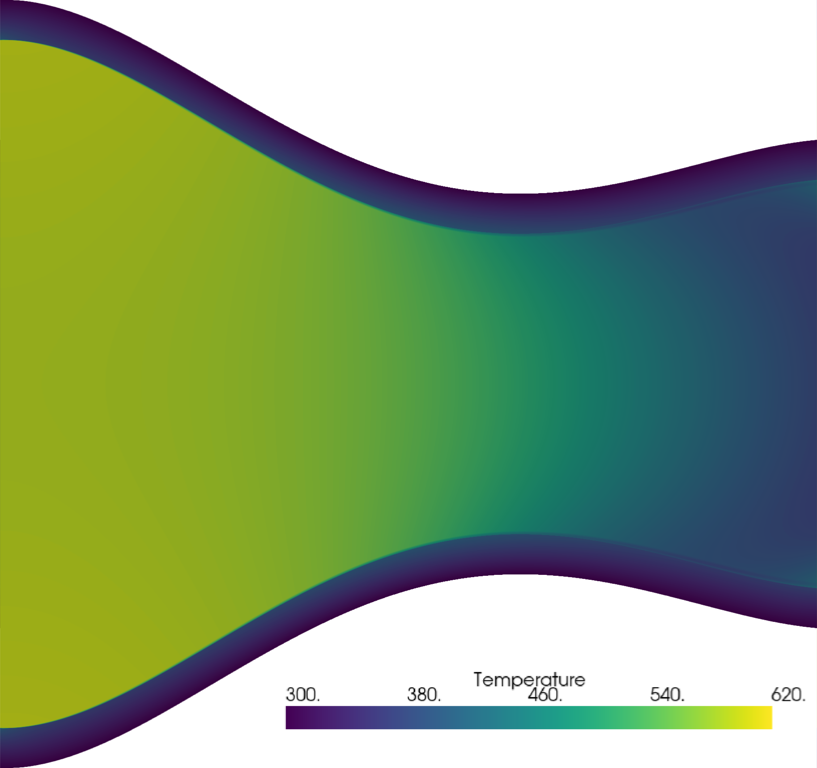

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


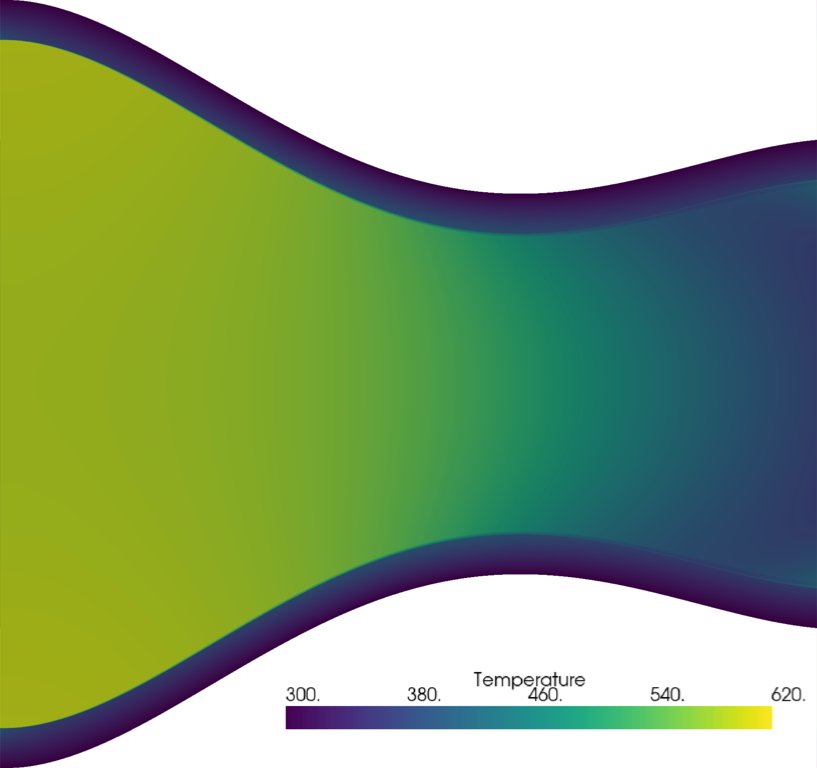

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


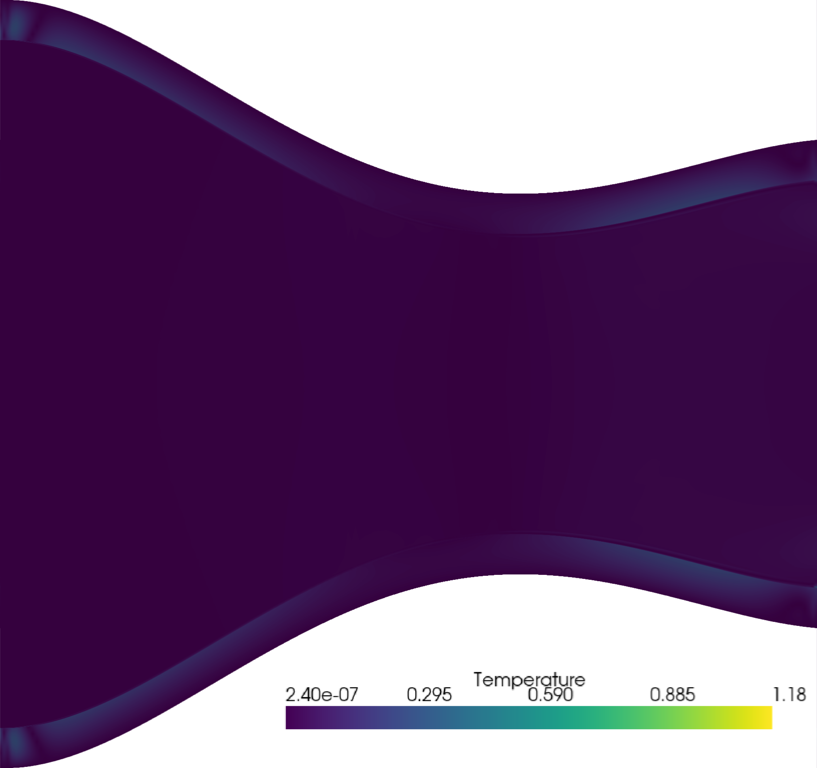

In [150]:
mesh = pv.read('/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/60/SU2/outputs/cht_setupSU2.vtm')

plot_reconstruction_var(mesh, 'Temperature', hf_reconstructed[:,5])
#plot_reconstruction_var(mesh, 'Pressure', hf_reconstructed[:,5])
#plot_reconstruction_var(mesh, 'Mach', hf_reconstructed[:,5])

In [151]:
error = {}
error['MAE'] = {}
error['NMAE'] = {}
error['NMAEP'] = {}
error['NRMSEP'] = {}
error['MSE'] = {}
error['RMSE'] = {}
error['NRMSE'] = {}
error['MAPE'] = {}
error['R2'] = {}
error['RSE'] = {}
error['RAE'] = {}
plot = False

for var in fr.hf_variables_dict:

    reconstructed = fr.hf_data_handler.get_variable(
        variable=var, data=hf_reconstructed)

    original = fr.hf_data_handler.get_variable(
        variable=var, data=fr.hf_data_handler.test)

    # error[var] = np.linalg.norm(abs(reconstructed-original)/original, axis=0)

    error['MAE'][var] = MAE(original, reconstructed)
    error['NMAE'][var] = NMAE(original, reconstructed)
    error['MSE'][var] = MSE(original, reconstructed)
    error['NRMSE'][var] = NRMSE(original, reconstructed)
    error['NMAEP'][var] = NMAEP(original, reconstructed)
    error['NRMSEP'][var] = NRMSEP(original, reconstructed)
    error['RMSE'][var] = RMSE(original, reconstructed)
    error['MAPE'][var] = MAPE(original, reconstructed)
    error['R2'][var] = R2(original, reconstructed)
    error['RSE'][var] = RSE(original, reconstructed)
    error['RAE'][var] = RAE(original, reconstructed)

    b, a = np.polyfit(original.flatten(), reconstructed.flatten(), deg=1)

    # Create sequence of 100 numbers from 0 to 100
    xseq = np.linspace(original.flatten().min(),
                       original.flatten().max(), num=100)

    if plot:
        # Plot regression line
        plt.figure(figsize=(3, 3))
        plt.plot(xseq, a + b * xseq, color="k",
                 label=f"R2={error['R2'][var]:.4f}")
        plt.scatter(original.flatten(), reconstructed.flatten(), alpha=0.5)
        plt.xlabel(var)
        plt.ylabel(f'predicted {var}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'./figures/results/{var}.png')
        plt.show()


In [152]:
def sub_dict(d, keys): return dict((key, d[key]) for key in keys)


d = dict(sub_dict(error, ['NMAEP', 'NRMSEP', 'R2']))

df = pd.DataFrame.from_dict(d)
df.style.format(precision=4)


,NMAEP,NRMSEP,R2
Temperature,1.5514,0.1043,1.0000
Temperature_Solid,2.5910,0.3929,0.9997
Temperature_Solid_INNERWALL,2.9465,0.7721,0.9993


In [89]:
error['NRMSE']


{'Temperature': 0.0017343266930987986,
 'Temperature_Solid': 0.00473006554176446,
 'Temperature_Solid_INNERWALL': 0.009214506666464414}

In [33]:
error['NMAE']


{'Pressure': 0.03884554700222038,
 'Temperature': 0.05848133800501638,
 'Mach': 0.06081000304286537,
 'Temperature_Solid': 0.06377559676597593,
 'Temperature_Solid_INNERWALL': 0.07252701799939916,
 'Heat_Flux_UPPER_WALL': 0.03191875788351459}

In [34]:
error['R2']


{'Pressure': 0.9980490459305227,
 'Temperature': 0.9959363242222175,
 'Mach': 0.996554378287294,
 'Temperature_Solid': 0.9936613134257891,
 'Temperature_Solid_INNERWALL': 0.9867479827966461,
 'Heat_Flux_UPPER_WALL': 0.9867647498689711}

In [35]:
# def projection_error():

# lf_train_reconstruction error
lf_projected = fr.lf_rom.reduce(fr.lf_data_handler.train)
lf_reconstructed = fr.lf_rom.reconstruct(lf_projected)
lf_original = fr.lf_data_handler.train
lf_train_reconstruction_error = NRMSE(lf_reconstructed, lf_original)

# hf_train_reconstruction error
hf_projected = fr.hf_rom.reduce(fr.hf_data_handler.train)
hf_reconstructed = fr.hf_rom.reconstruct(hf_projected)
hf_original = fr.hf_data_handler.train
hf_train_reconstruction_error = NRMSE(hf_reconstructed, hf_original)


In [36]:
# lf_train_reconstruction error
lf_projected = fr.lf_rom.reduce(fr.lf_data_handler.validation)
lf_reconstructed = fr.lf_rom.reconstruct(lf_projected)
lf_original = fr.lf_data_handler.validation
lf_validation_reconstruction_error = NRMSE(lf_reconstructed, lf_original)

# hf_train_reconstruction error
hf_projected = fr.hf_rom.reduce(fr.hf_data_handler.validation)
hf_reconstructed = fr.hf_rom.reconstruct(hf_projected)
hf_original = fr.hf_data_handler.validation
hf_validation_reconstruction_error = NRMSE(hf_reconstructed, hf_original)


In [37]:
# lf_train_reconstruction error
lf_projected = fr.lf_rom.reduce(fr.lf_data_handler.test)
lf_reconstructed = fr.lf_rom.reconstruct(lf_projected)
lf_original = fr.lf_data_handler.test
lf_test_reconstruction_error = NRMSE(lf_reconstructed,lf_original)

# hf_train_reconstruction error
hf_projected = fr.hf_rom.reduce(fr.hf_data_handler.test)
hf_reconstructed = fr.hf_rom.reconstruct(hf_projected)
hf_original = fr.hf_data_handler.test
hf_test_reconstruction_error = NRMSE(hf_reconstructed,hf_original)

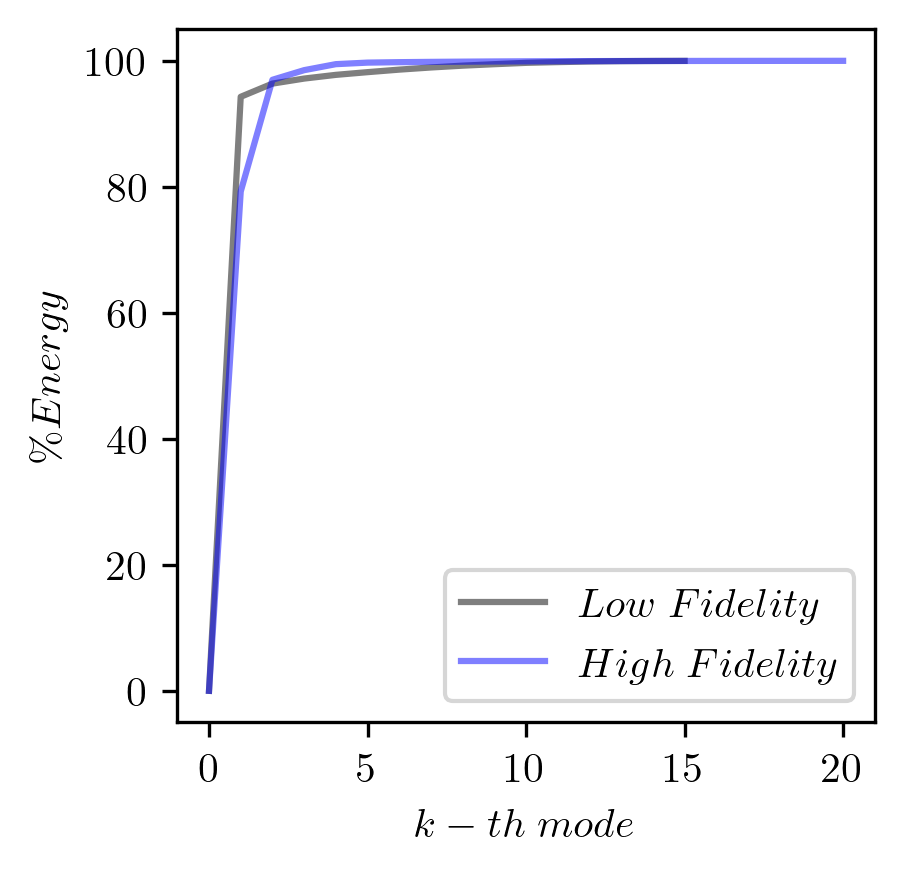

<Figure size 1920x1440 with 0 Axes>

In [38]:
fig, ax = plt.subplots(figsize=(3, 3))

lf_svd_energy = np.loadtxt('./figures/lf_svd_energy.txt',  delimiter=',')
hf_svd_energy = np.loadtxt('./figures/hf_svd_energy.txr',   delimiter=',')


ax.plot(lf_svd_energy, label=r"$Low\; Fidelity$", c='k', alpha=0.5)
ax.plot(hf_svd_energy, label=r"$High\; Fidelity$", c='blue', alpha=0.5)
plt.xlabel(r"$k-th\; mode$")
plt.ylabel(r"$\% Energy$")

plt.legend()
plt.show()
plt.savefig('./figures/svd_energy.pdf')


In [39]:
!pip install keras-visualizer


In [40]:
from keras_visualizer import visualizer

visualizer(model=fr.surrogate.nn, file_name='./figures/nn.pdf',
           file_format='pdf', view=True)


In [41]:
from keras.utils.vis_utils import plot_model
plot_model(fr.surrogate.nn, to_file='./figures/keras.pdf',
           show_shapes=True, show_layer_names=True)


In [42]:
90*60/10.6


509.433962264151

In [43]:
Sure, here are some relevant references for SVD, POD, flow reconstruction, and neural networks in the context of fluid dynamics:

- Golub, G. H., and C. F. Van Loan. Matrix Computations. 4th ed., Johns Hopkins University Press, 2013. (Reference for SVD)

- Lumley, J. L. "The Structure of Inhomogeneous Turbulent Flows." Atmospheric Turbulence and Radio Wave Propagation, edited by J. L. Lumley, vol. 2, Springer-Verlag, 1967, pp. 166-178. (Reference for POD)

- Iliescu, T., and J. M. Nordbotten. "Reduced-Order Modeling of Flow Problems." Annual Review of Fluid Mechanics, vol. 52, no. 1, 2020, pp. 455-484. (Reference for flow reconstruction)

- Liao, W., et al. "Reduced-Order Modeling of Turbulent Flow in a Combustion Chamber with Deep Neural Networks." Combustion Theory and Modelling, vol. 24, no. 4, 2020, pp. 632-652. (Reference for neural networks in fluid dynamics)

- Brunton, S. L., and J. N. Kutz. Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control. Cambridge University Press, 2019. (Reference for neural networks in general)


SyntaxError: invalid decimal literal (3072652521.py, line 3)


(evince:312874): IBUS-WARNING **: 06:36:24.772: The owner of /home/ppiper/.config/ibus/bus is not ppiper!
